In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap

In [2]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [3]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
# Display basic info
print("Initial Data Shape:", df.shape)
df.head()

Initial Data Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# 2. Data Cleaning
# Fix TotalCharges column (convert to numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Fix the warning by using assignment instead of inplace
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convert target variable to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [7]:
# 3. Feature Engineering
# Create tenure groups
df['tenure_group'] = pd.cut(df['tenure'],
                            bins=[0, 12, 24, 36, 48, 60, 72],
                            labels=['1-12', '13-24', '25-36', '37-48', '49-60', '61-72'])

# Create interaction features
df['MonthlyCharges_Tenure'] = df['MonthlyCharges'] * df['tenure']

# Create service bundle count
service_cols = ['PhoneService', 'MultipleLines', 'InternetService',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']

df['ServiceCount'] = df[service_cols].apply(lambda x: x.eq('Yes').sum(), axis=1)


In [8]:
# Payment history features (simulated)
np.random.seed(42)
df['LatePayments_12mo'] = np.random.randint(0, 5, size=len(df))
df['AvgPaymentDelay'] = np.random.exponential(scale=2, size=len(df))

In [9]:
# 4. Data Preprocessing
# Drop unnecessary columns
df.drop(['customerID', 'tenure'], axis=1, inplace=True)

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']


In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Handle categorical variables
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [12]:
# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [14]:
# 5. Model Training and Evaluation
# Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(rf, param_grid, cv=3)
grid.fit(X_train_sm, y_train_sm)
rf_pred = grid.predict(X_test)
rf_proba = grid.predict_proba(X_test)[:,1]


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

# Logistic Regression with scaled data
lr = LogisticRegression(max_iter=1000, solver='saga')  # Added solver
lr.fit(X_train_sm, y_train_sm)
lr_pred = lr.predict(X_test_scaled)  # Use scaled test data

--- Logistic Regression Results ---
ROC-AUC: 0.8361454138934031
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81      1036
           1       0.52      0.81      0.63       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409



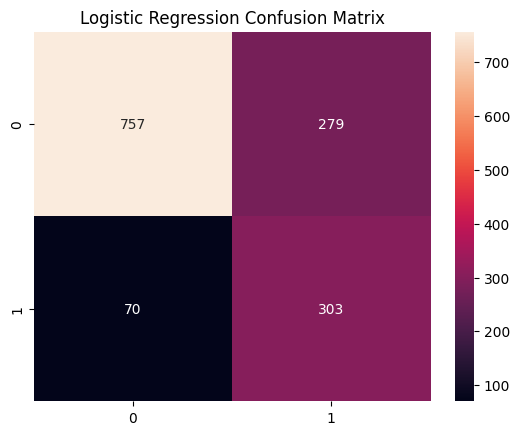

--- Random Forest Results ---
ROC-AUC: 0.8545317627087063
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      1036
           1       0.59      0.69      0.64       373

    accuracy                           0.79      1409
   macro avg       0.74      0.76      0.75      1409
weighted avg       0.81      0.79      0.80      1409



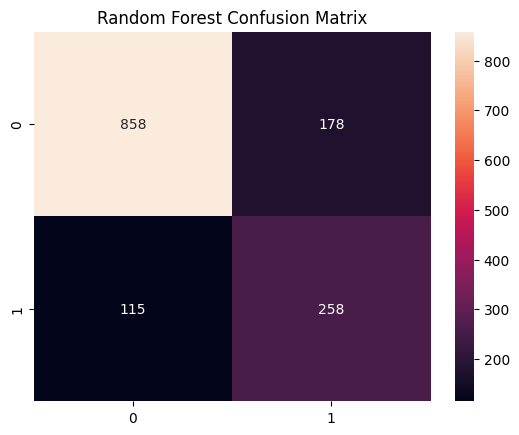

In [17]:
# 6. Model Comparison
def evaluate_model(y_true, y_pred, y_proba, name):
    print(f"--- {name} Results ---")
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

evaluate_model(y_test, lr_pred, lr_proba, 'Logistic Regression')
evaluate_model(y_test, rf_pred, rf_proba, 'Random Forest')


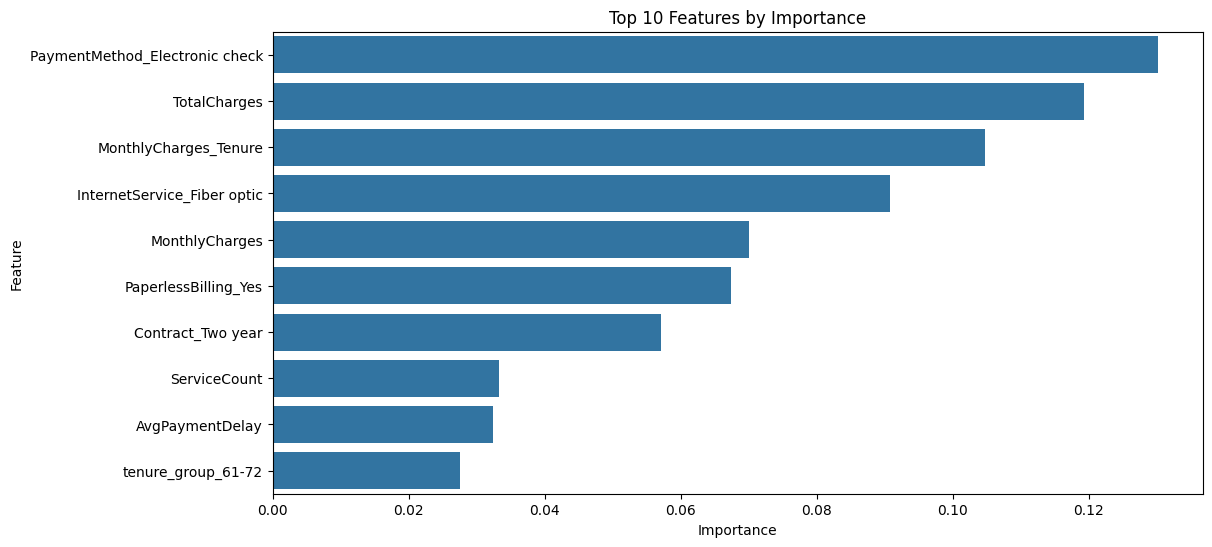

In [18]:
# 7. Feature Importance Analysis
# For Random Forest
importances = grid.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features by Importance')
plt.show()

<Figure size 1200x1200 with 0 Axes>

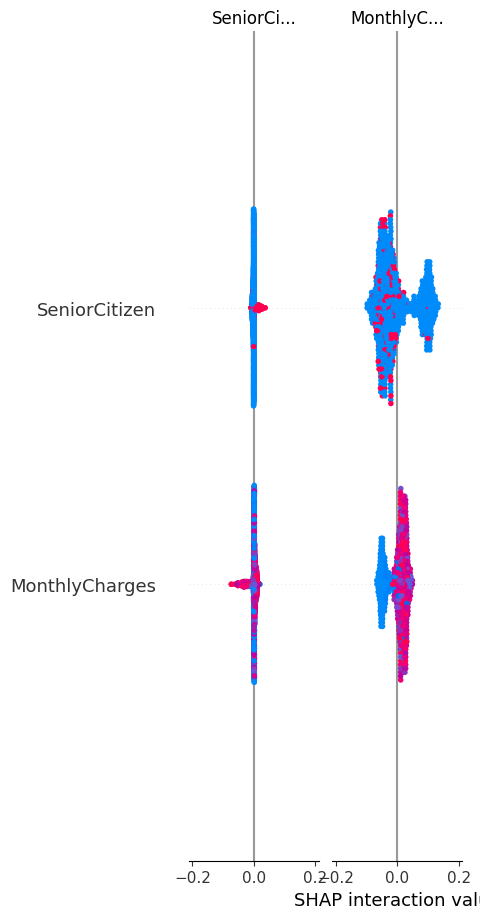

In [20]:
# SHAP values for model explanation
explainer = shap.TreeExplainer(grid.best_estimator_)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(12, 12))
shap.summary_plot(shap_values, X_test, max_display=10)
plt.show()

In [21]:
# 8. Business Impact Simulation
def calculate_savings(model, X_test, y_test):
    predictions = model.predict(X_test)
    retention_cost = 50  # Cost of retention offer
    customer_value = 60  # Average monthly revenue per customer

    # Customers who would churn but were retained
    true_positives = ((predictions == 1) & (y_test == 1)).sum()

    # Calculate net savings
    saved_customers = true_positives * (customer_value - retention_cost)
    total_churners = y_test.sum()

    return saved_customers, (saved_customers / (total_churners * customer_value)) * 100

In [24]:
rf_savings, rf_savings_pct = calculate_savings(grid.best_estimator_, X_test, y_test)
print(f"Estimated Monthly Savings: ${rf_savings:.2f}")
print(f"Percentage of Potential Loss Recovered: {rf_savings_pct:.2f}%")

# 9. Model Persistence
import joblib
joblib.dump(grid.best_estimator_, 'model/churn_model.pkl')

Estimated Monthly Savings: $2580.00
Percentage of Potential Loss Recovered: 11.53%


['model/churn_model.pkl']